# Experiments executor for the Random-pMedici mix project

In [264]:
# Library imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

### Set which dataset to use

In [265]:
COMPLEXITY = "low"
MCA = False
DATASET = "experiments_multipleRepts2_50models_" + ("MCA_" if MCA else "") + COMPLEXITY + ".csv"

# Import the experiment data
data = pd.read_csv(DATASET)

# Group by the experiment number
grouped = data.groupby(["FileName","t","k","v","SeedSize"])
# For the other columns (UsedSeedSize,TSSize,TSTime,cRnd,cInc,totTuples,relCRnd,relCInc) compute the average for each group
data = grouped.agg({"UsedSeedSize":np.mean,"TSSize":np.mean,"TSTime":np.mean,"cRnd":np.mean,"cInc":np.mean,"totTuples":np.mean,"relCRnd":np.mean,"relCInc":np.mean})
# Convert data into a dataframe
data = pd.DataFrame(data).reset_index()
# Round the column UsedSeedSize to the nearest integer
data["UsedSeedSize"] = data["UsedSeedSize"].round(0).astype(int)

## Function definitions

In [266]:
def plot_data(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name concatenated with k and t, on the Y axis the usedSeedSize in a series, and the expectedSeedSize in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].usedSeedSize, 'r^', data[(data.t == t)].model, data[(data.t == t)].expectedSeedSize, 'bs')
    plt.xticks(rotation = 90)
    plt.title('Best Used Seed Size vs Expected Seed Size (t = ' + str(t) + ') - ' + label)
    plt.legend(['Used Seed Size', 'Expected Seed Size', 'Baseline'])	
    plt.ylabel('Seed Size [Num Test Cases]')
    plt.show()

In [267]:
def plot_expected_data_time(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name, on the Y axis the obtainedBestTime in a series, and the exptcBestTime in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].obtainedBestTime, 'r^', data[(data.t == t)].model, data[(data.t == t)].expctBestTime, 'bs', data[(data.t == t)].model, data[(data.t == t)].baseline, 'go')
    plt.xticks(rotation = 90)
    plt.title('Expected Best Time vs Obtained Best Time (t = '+ str(t)+') - ' + label)
    plt.legend(['Obtained Best Time', 'Expected Best Time', 'Baseline'])
    plt.ylabel("Time [ms]")
    plt.show()

In [268]:
def plot_expected_data_size(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name, on the Y axis the obtainedBestSize in a series, and the exptcBestSioze in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].obtainedBestSize, 'r^', data[(data.t == t)].model, data[(data.t == t)].expctBestSize, 'bs', data[(data.t == t)].model, data[(data.t == t)].baseline, 'go')
    plt.xticks(rotation = 90)
    plt.title('Expected Best Size vs Obtained Best Size (t = '+ str(t)+') - ' + label)
    plt.legend(['Obtained Best Size', 'Expected Best Size', 'Baseline'])	
    plt.ylabel("Size [Num Test Cases]")
    plt.show()

In [269]:
def plot_coveredTuples(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name, on the Y axis the usedSeedSize in a series, and the expectedSeedSize in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].covTuples, 'r^')
    plt.xticks(rotation = 90)
    plt.title('C RND in the best case scenario (t = ' + str(t) + ') - ' + label)
    plt.legend(['Covered Tuples [%]'])
    plt.show()

In [270]:
def reduction_factor(v):
    #return (1 / (2* float(v) - 1)) + (2/3))
    #return (1 / (float(v) - 1)) 
    #return 1 / ((2/3) * v - 1/3)
    return 1

## Data preparation

In [271]:
# Remove all rows having 'timeout' in the TSSize column
data = data[data.TSSize != 'timeout'] 

# Set the correct data types for all columns
data['TSTime'] = data['TSTime'].astype(float)
data['TSSize'] = data['TSSize'].astype(float)
data['cRnd'] = pd.to_numeric(data['cRnd'])
data['cInc'] = pd.to_numeric(data['cInc'])
data['relCRnd'] = pd.to_numeric(data['relCRnd'])
data['relCInc'] = pd.to_numeric(data['relCInc'])

In [272]:
# Update the FileName column by concatenating its value with the value of the column k and that of v
data['FileName'] = data['FileName'] + ' -> k=' + data['k'].astype(str) + ', v=' + data['v'].astype(str)

In [273]:
# Summary data
cInc = data['relCInc'].mean()
print("Average relCInc: " + str(cInc))
print("Average relCRnd: " + str(data['relCRnd'].mean()))
print("----------")
# For all the possible values of the column t, compute the averate relCInc and relCRnd
for t in data.t.unique():
    print("t = " + str(t))
    print("Average relCInc: " + str(data[data.t == t]['relCInc'].mean()) + " - std dev. " + str(data[data.t == t]['relCInc'].std())) 
    print("Average relCRnd: " + str(data[data.t == t]['relCRnd'].mean()) + " - std dev. " + str(data[data.t == t]['relCRnd'].std()))
    print("----------")

Average relCInc: 0.03353183525150974
Average relCRnd: 0.27908218066151175
----------
t = 2
Average relCInc: 0.03353183525150974 - std dev. 0.06156598274887758
Average relCRnd: 0.27908218066151175 - std dev. 0.2438822705911087
----------


## Best execution (*time*)

In [274]:
# New dataframe associating the model with the expected seed size
expectedSizes = pd.DataFrame(columns=['model', 'expectedSeedSize', 't', 'usedSeedSize', 'k', 'v'])

# For each model in FileName, extract the line with the best TSTime
for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        
        weighted_v = float(v) * reduction_factor(v)
        
        expectedSizes.loc[len(expectedSizes.index)] = [model, 
                                                       math.log10( -(cInc * weighted_v ** (-t))/(math.log10( 1 - float(weighted_v) ** (-t))) ) / math.log10( 1 - float(weighted_v) ** (-t)),
                                                       t,
                                                       data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSTime']).head(1).iloc[0]['UsedSeedSize'],
                                                       k,
                                                       v]
        
print (expectedSizes.shape)

(50, 6)


In [275]:
# First, order the data by k
expectedSizes = expectedSizes.sort_values(by=['k', 'v', 'model'])

In [276]:
times = pd.DataFrame(columns=['model', 'expctBestTime', 'obtainedBestTime', 't', 'k', 'baseline', 'v'])

# Extract the time obtained when using the "Used Seed Size" and that using the "Expected Seed Size"
for t in data.t.unique():
    for model in data.FileName.unique():         
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        
        if (data[(data.t == t) &
                 (data.FileName == model) &
                 (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                 (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].empty): continue
          
        times.loc[len(times.index)] = [model,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].iloc[0]['TSTime'],
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['usedSeedSize']))].iloc[0]['TSTime'],
                                       t,
                                       k,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == 0)].iloc[0]['TSTime'],
                                       v]
        
print (times.shape)

(50, 7)


In [277]:
# First, order the data by k
times = times.sort_values(by=['k', 'v', 'model'])

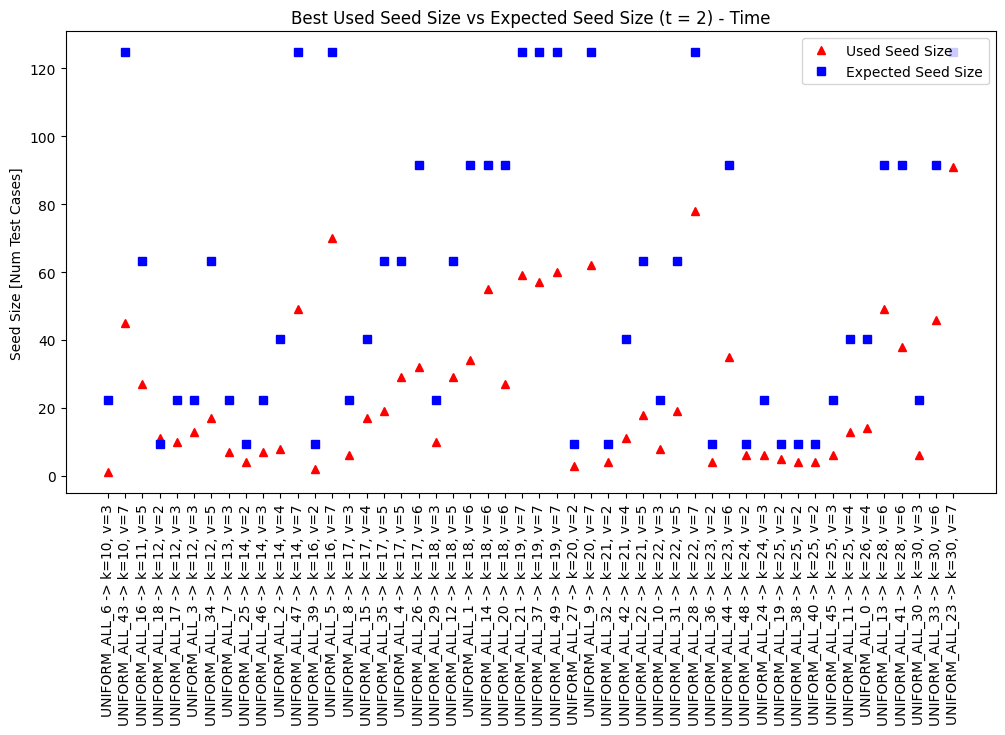

In [278]:
plot_data(2, expectedSizes, 'Time')

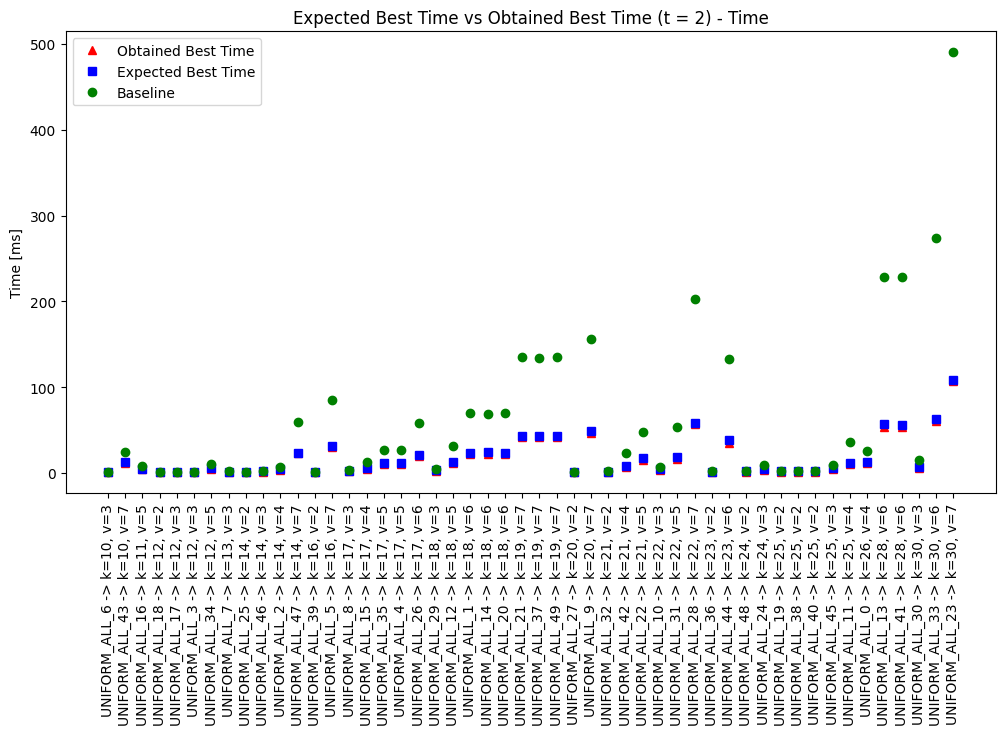

In [279]:
plot_expected_data_time(2, times, 'Time')

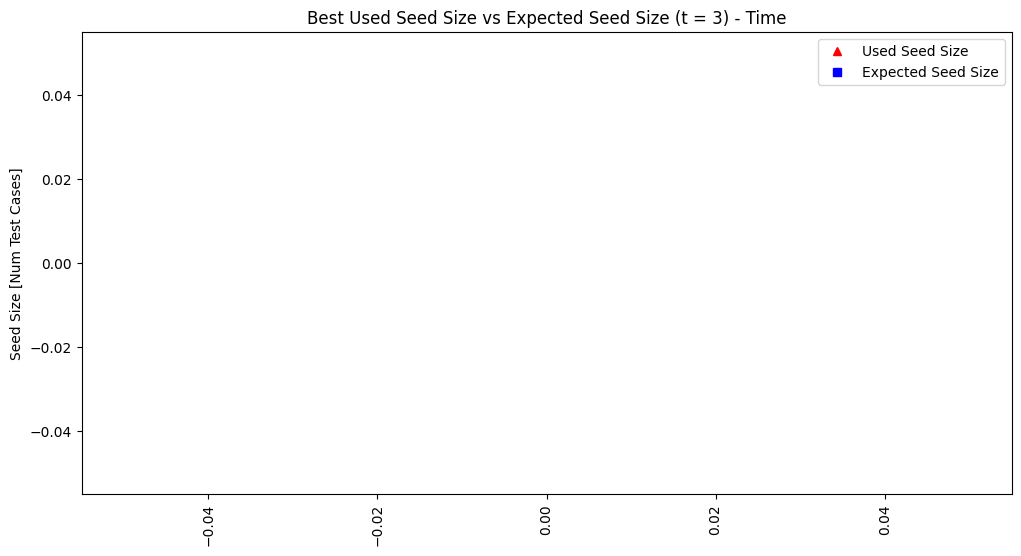

In [280]:
plot_data(3, expectedSizes, 'Time')

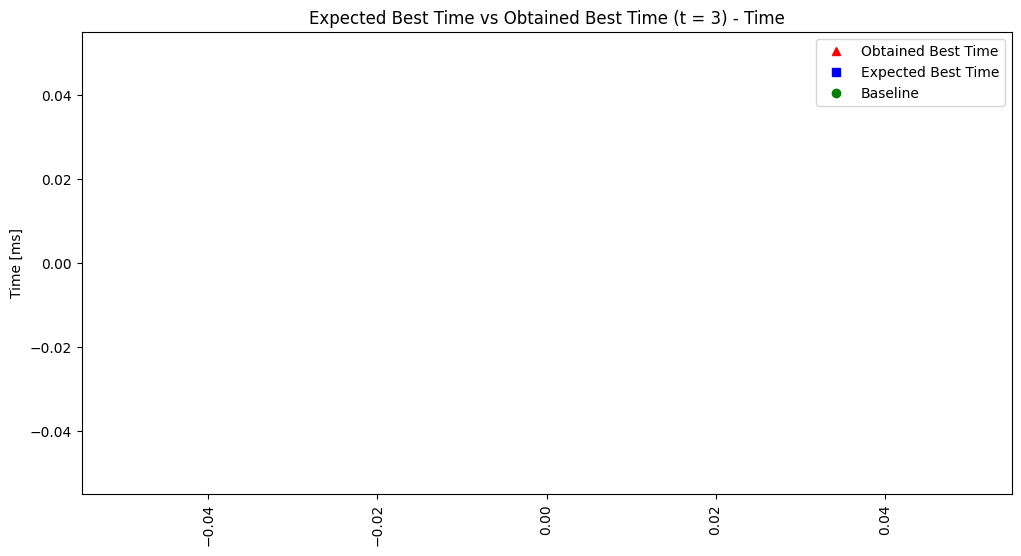

In [281]:
plot_expected_data_time(3, times, 'Time')

## Best Execution (*size*)

In [282]:
# New dataframe associating the model with the expected seed size
expectedSizes = pd.DataFrame(columns=['model', 'expectedSeedSize', 't', 'usedSeedSize', 'k', 'v'])

# For each model in FileName, extract the line with the best TSSize
for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        
        weighted_v = float(v) * reduction_factor(v)
        
        expectedSizes.loc[len(expectedSizes.index)] = [model,
                                                       math.log10( -(cInc * float(weighted_v) ** (-t))/(math.log10( 1 - float(weighted_v) ** (-t))) ) / math.log10( 1 - float(weighted_v) ** (-t)), 
                                                       t,
                                                       data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSSize']).head(1).iloc[0]['UsedSeedSize'],
                                                       k, 
                                                       v]
        
print(expectedSizes.shape)

(50, 6)


In [283]:
# First, order the data by k
expectedSizes = expectedSizes.sort_values(by=['k', 'v', 'model'])

In [284]:
sizes = pd.DataFrame(columns=['model', 'expctBestSize', 'obtainedBestSize', 't', 'k', 'baseline', 'v'])

# Extract the size obtained when using the "Used Seed Size" and that using the "Expected Seed Size"
for t in expectedSizes.t.unique():
    for model in expectedSizes.model.unique():         
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
                
        if (data[(data.t == t) &
                 (data.FileName == model) &
                 (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                 (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].empty): continue
          
        sizes.loc[len(sizes.index)] = [model,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].iloc[0]['TSSize'],
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['usedSeedSize']))].iloc[0]['TSSize'],
                                       t,
                                       k,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == 0)].iloc[0]['TSSize'],
                                       v]

print(sizes.shape)

(50, 7)


In [285]:
# First, order the data by k in ascending order
sizes = sizes.sort_values(by=['k', 'v', 'model'])

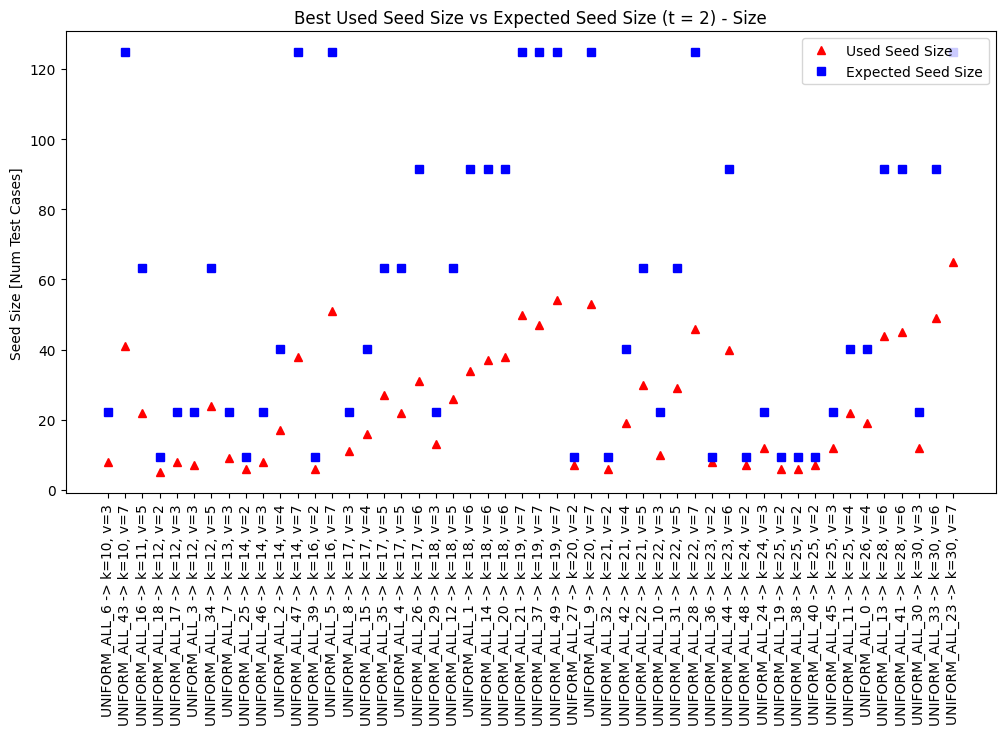

In [286]:
plot_data(2, expectedSizes, 'Size')

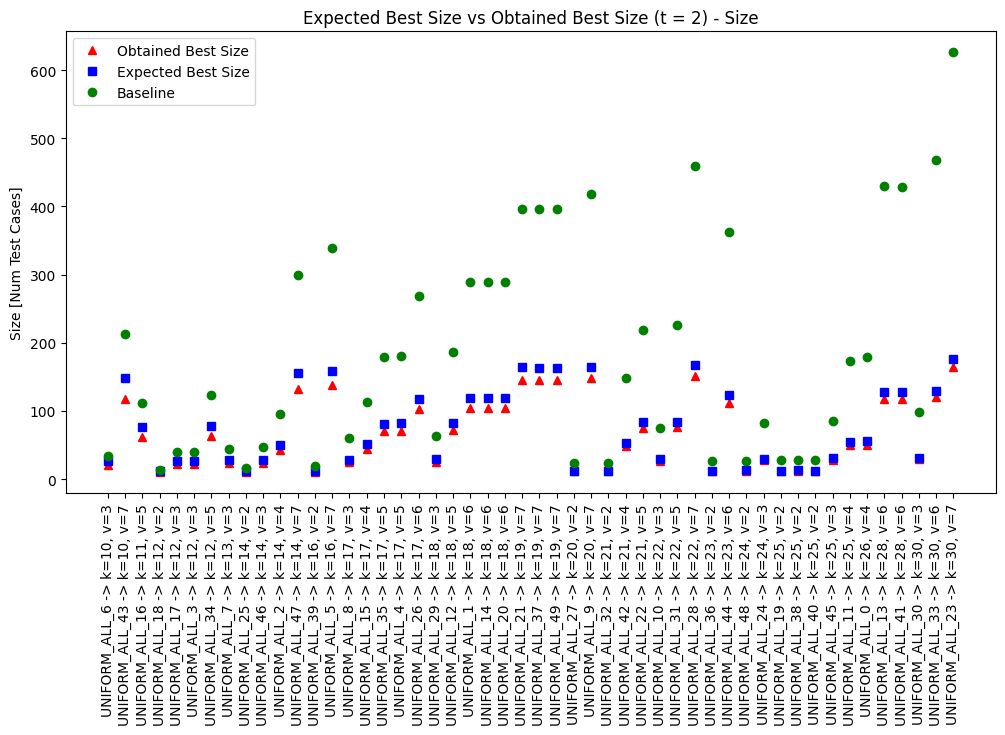

In [287]:
plot_expected_data_size(2, sizes, 'Size')

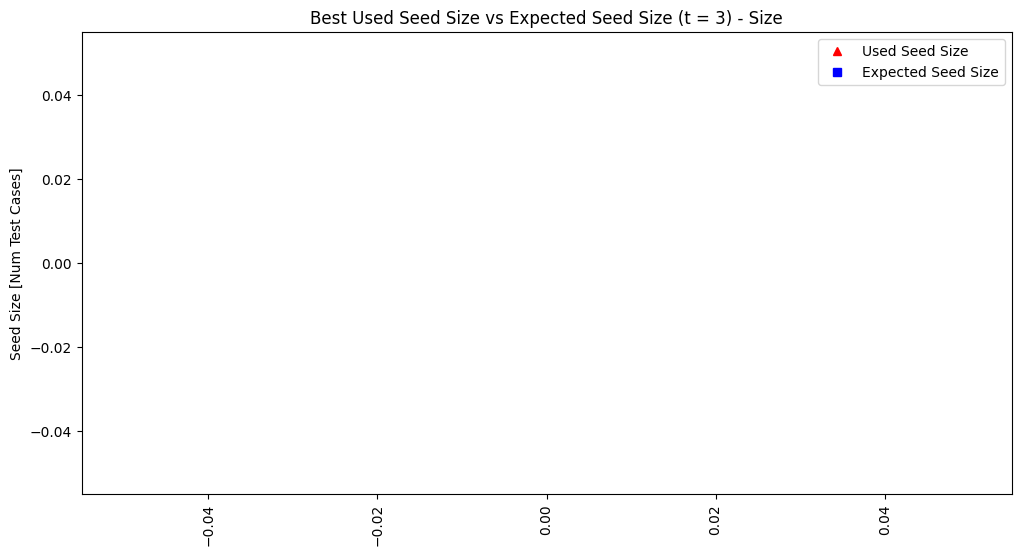

In [288]:
plot_data(3, expectedSizes, 'Size')

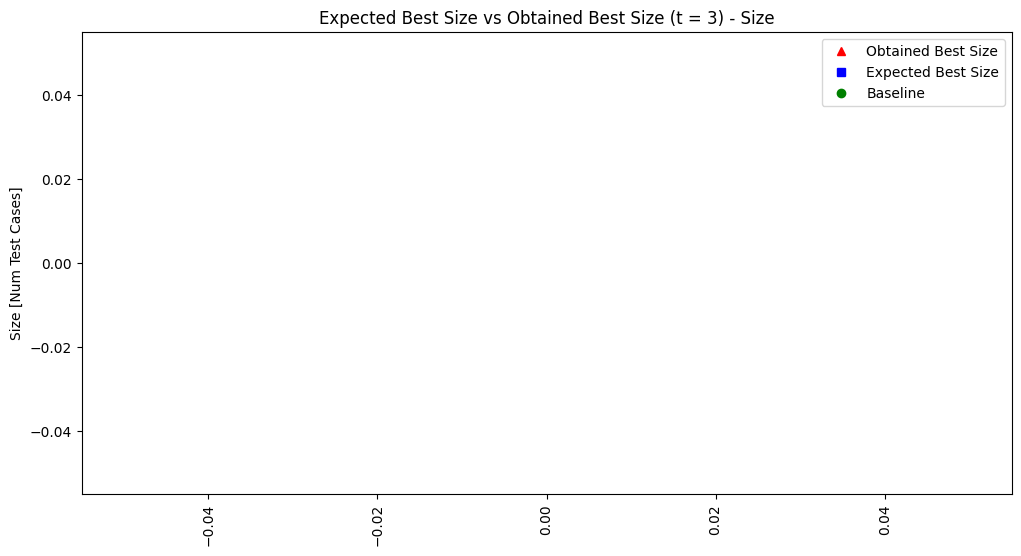

In [289]:
plot_expected_data_size(3, sizes, 'Size')

## Percentage of covered tuples by the random part in the best-case scenario (Size)

In [290]:
tuples = pd.DataFrame(columns=['model', 'covTuples', 't', 'k', 'v'])

for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        
        totTuples = data[(data.t == t) & (data.FileName == model)].iloc[0]['totTuples']
        
        tuples.loc[len(tuples.index)] = [model,
                                         (data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSSize']).head(1).iloc[0]['cRnd']  * data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSSize']).head(1).iloc[0]['UsedSeedSize']) / totTuples,
                                         t,
                                         k,
                                         v]
        
print(tuples.shape)

(50, 5)


In [291]:
# First, order the data by k in ascending order
tuples = tuples.sort_values(by=['k', 'v', 'model'])

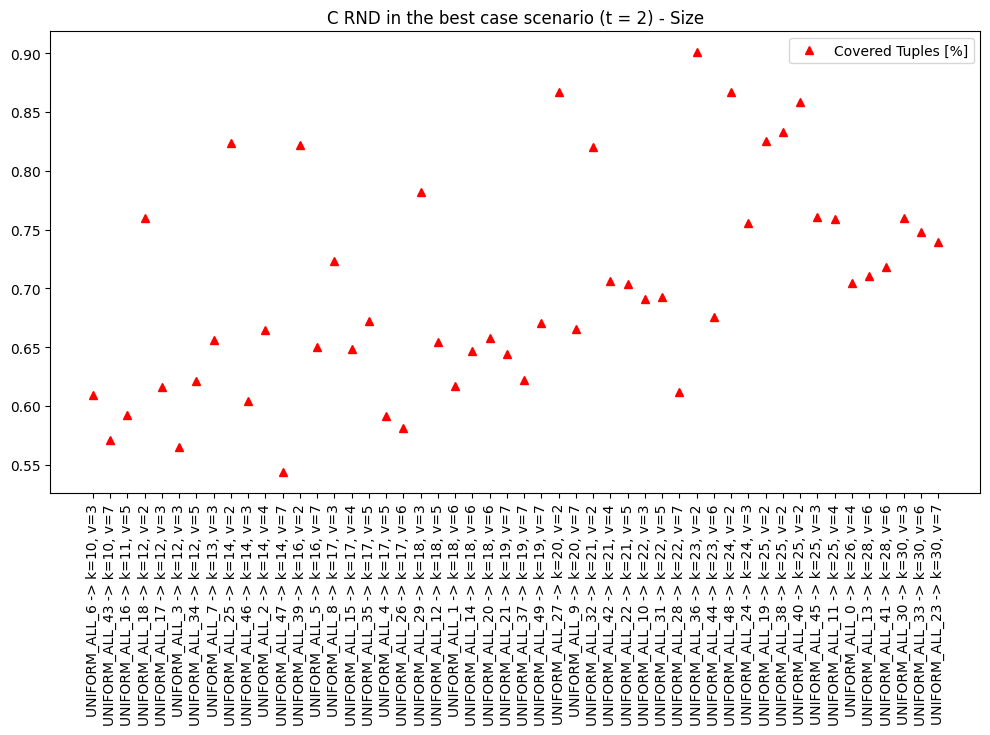

In [292]:
plot_coveredTuples(2, tuples, 'Size')

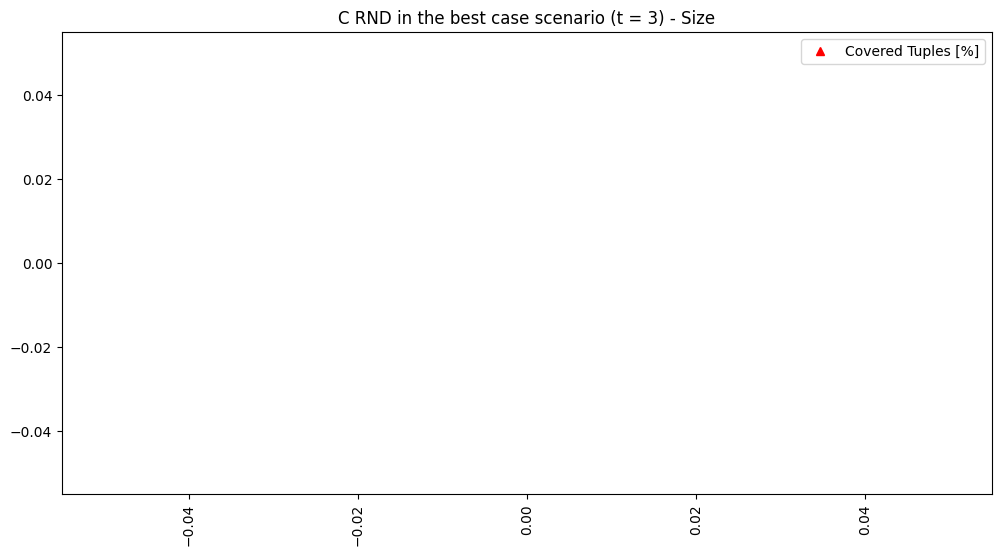

In [293]:
plot_coveredTuples(3, tuples, 'Size')

## Percentage of covered tuples by the random part in the best-case scenario (Time)

In [294]:
tuples = pd.DataFrame(columns=['model', 'covTuples', 't', 'k','v'])

for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        
        totTuples = data[(data.t == t) & (data.FileName == model)].iloc[0]['totTuples']
        
        tuples.loc[len(tuples.index)] = [model,
                                         (data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSTime']).head(1).iloc[0]['cRnd']  * data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSTime']).head(1).iloc[0]['UsedSeedSize']) / totTuples,
                                         t,
                                         k,
                                         v]
        
print (tuples.shape)

(50, 5)


In [295]:
# First, order the data by k in ascending order
tuples = tuples.sort_values(by=['k', 'v', 'model'])

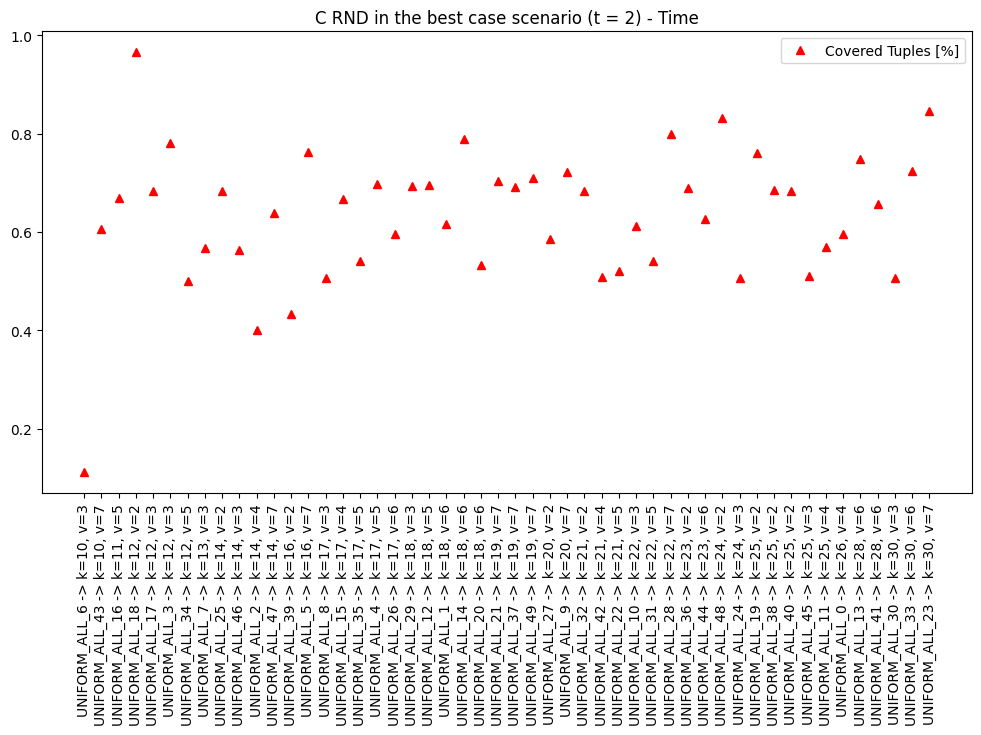

In [296]:
plot_coveredTuples(2, tuples, 'Time')

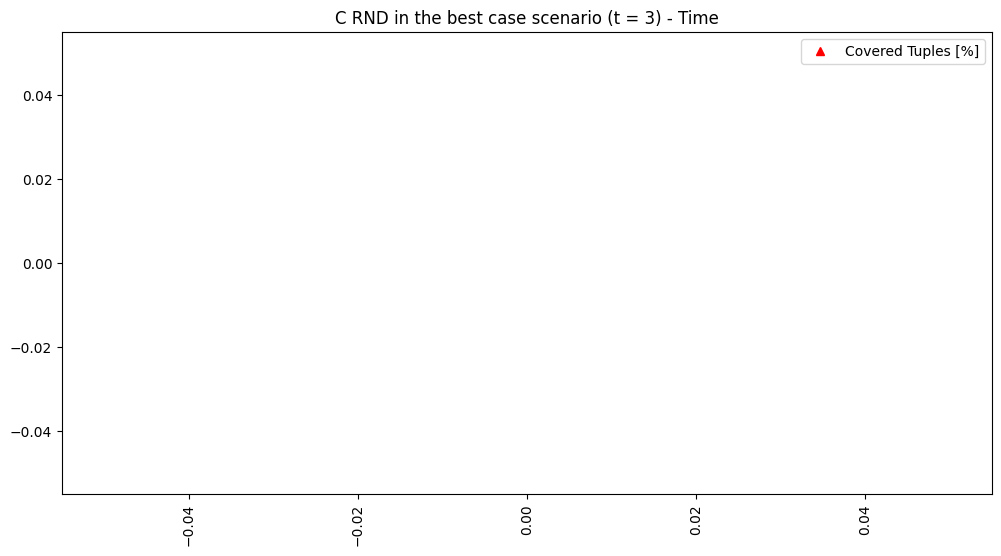

In [297]:
plot_coveredTuples(3, tuples, 'Time')

## Plot with different c values

In [298]:
import scipy.special

def computeN1 (c, v, t, k):
    return math.log10(-(c * v**(np.float_(-t)))/(scipy.special.comb(k, t) * math.log10(1-v**(np.float_(-t)))))/math.log10(1-v**(np.float_(-t)))

In [299]:
def add_to_dataframe(data, c, data_c, modelName, t):
    if (c == 'k/t'):
        c_val = data[(data.FileName == model) & (data.t == t)].iloc[0]['k'] / t
    elif (c=='1'):
        c_val = 1
    elif (c=='(k t)'):
        c_val = scipy.special.comb(data[(data.FileName == model) & (data.t == t)].iloc[0]['k'], t)
    
    # Compute the N1 for this model with c
    n1 = round(computeN1(c_val, data[(data.FileName == model) & (data.t == t)].iloc[0]['v'], t, data[(data.FileName == model) & (data.t == t)].iloc[0]['k']))
    
    if (n1 < 0):
        n1 = 0
        
    print(modelName + " " + str(n1))
    
    # Extract the size
    size = data[(data.FileName.str.startswith(modelName + " ")) & (data.t == t) & (data.SeedSize == n1)].iloc[0]['TSSize']
    
    # Append to data_c
    data_c.loc[len(data_c.index)] = [modelName, c_val, size]

UNIFORM_ALL_10 40
UNIFORM_ALL_10 19
UNIFORM_ALL_10 0
UNIFORM_ALL_18 12
UNIFORM_ALL_18 6
UNIFORM_ALL_18 0
UNIFORM_ALL_20 149
UNIFORM_ALL_20 71
UNIFORM_ALL_20 0
UNIFORM_ALL_24 41
UNIFORM_ALL_24 20
UNIFORM_ALL_24 0
UNIFORM_ALL_29 36
UNIFORM_ALL_29 17
UNIFORM_ALL_29 0
UNIFORM_ALL_32 16
UNIFORM_ALL_32 8
UNIFORM_ALL_32 0
UNIFORM_ALL_33 187
UNIFORM_ALL_33 90
UNIFORM_ALL_33 0
UNIFORM_ALL_34 83
UNIFORM_ALL_34 39
UNIFORM_ALL_34 0
UNIFORM_ALL_35 100
UNIFORM_ALL_35 48
UNIFORM_ALL_35 0
UNIFORM_ALL_36 17
UNIFORM_ALL_36 8
UNIFORM_ALL_36 0
UNIFORM_ALL_39 14
UNIFORM_ALL_39 7
UNIFORM_ALL_39 0
UNIFORM_ALL_40 17
UNIFORM_ALL_40 9
UNIFORM_ALL_40 0
UNIFORM_ALL_46 32
UNIFORM_ALL_46 15
UNIFORM_ALL_46 0
UNIFORM_ALL_6 26
UNIFORM_ALL_6 12
UNIFORM_ALL_6 0


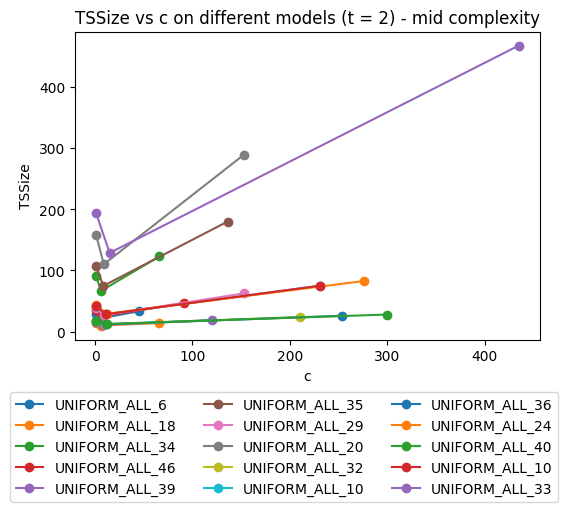

In [300]:
# Models to be kept for this plot
models_to_be_kept = pd.read_csv("models_c.csv")
models_to_be_kept = models_to_be_kept[models_to_be_kept['Complexity'] == COMPLEXITY]

# Create a new dataframe with the model, the value of c, and the value of TSSize
data_c = pd.DataFrame(columns=['model', 'c', 'TSSize'])

# Iterate over all models in data
for model in data.FileName.unique(): 
    for t in data.t.unique():   
        modelName = model.split(" ")[0]
        
        # If the model is not in the list of models to be kept, skip it
        if modelName not in models_to_be_kept['ModelName'].values:
            continue
        
        add_to_dataframe(data, '1', data_c, modelName, t)
        add_to_dataframe(data, 'k/t', data_c, modelName, t)
        add_to_dataframe(data, '(k t)', data_c, modelName, t)

# Plot the data_c dataframe in a xy chart grouping in different series by model
plt.figure(figsize=(6,4))
for model in models_to_be_kept['ModelName']:
    plt.plot(data_c[(data_c.model == model)].c, data_c[(data_c.model == model)].TSSize, 'o-')
# Add the legend
plt.legend(models_to_be_kept['ModelName'], ncol = 3, loc='lower center', bbox_to_anchor=(0.45, -0.55))
# Add the label on axis
plt.xlabel('c')
plt.ylabel('TSSize')
plt.title('TSSize vs c on different models (t = 2) - ' + COMPLEXITY + " complexity")
# Export in PDF
plt.savefig('TSSize_vs_c_t2_' + COMPLEXITY + '.pdf', bbox_inches='tight')
    
        